# Dados

### PIB per capita

O IBGE produz, anualmente, estimativas do [Produto Interno Bruto dos municípios](https://www.ibge.gov.br/estatisticas-novoportal/economicas/contas-nacionais/9088-produto-interno-bruto-dos-municipios.html). Os dados, prontos para uso, estão disponíveis para download, de modo que não é necessário aplicar métodos especiais de coleta ou tratamento dos dados.

Conforme esperado, os municípios diferem significativamente em PIB per capita, com muitos municípios relativamente pobres e poucos municípios relativamente ricos (cauda à direita da Figura 1, a seguir).

Text(0.5,0,'PIB per capita (log)')

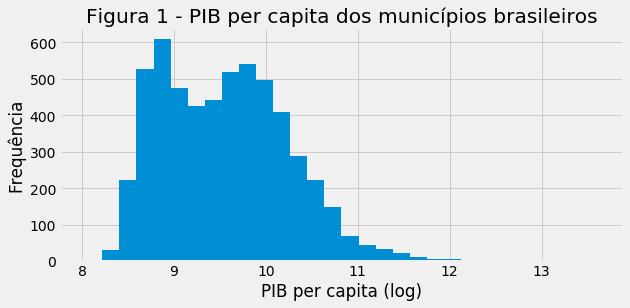

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pib = pd.read_excel("data/raw/pib_mun.xls")
pib = pib[["cod_ibge", "pib_pc"]]
pib["log_pib_pc"] = pib["pib_pc"].apply(np.log)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(9,4))

pib.log_pib_pc.hist(bins=30)

plt.title('Figura 1 - PIB per capita dos municípios brasileiros')
plt.ylabel('Frequência')
plt.xlabel('PIB per capita (log)')


### Histórico dos municípios

O IBGE disponibiliza, no site [IBGE Cidades](https://cidades.ibge.gov.br/), um registro histórico para cada um dos 5.570 municípios brasileiros. A maior parte dos registros é oriunda da [Enciclopédia dos Municípios Brasileiros](https://biblioteca.ibge.gov.br/index.php/biblioteca-catalogo?view=detalhes&id=227295), de elaboração do próprio IBGE.

Vejamos um trecho retirado do histórico do município de [São João Del-Rei](https://cidades.ibge.gov.br/brasil/mg/sao-joao-del-rei/historico):

    Em busca de esmeraldas, a bandeira de Fernão Dias Pais Leme foi, no ano de 1674, forçada a passar a estação chuvosa na 
    Serra Negra, onde fundou o primitivo arraial das Minas Gerais – Ibituruna, distante doze léguas da atual cidade de São 
    João Del Rei, a cujo município pertenceu até 1922. Os cascalhos auríferos da bacia do rio das Mortes, que “assoalhavam o caminho trilhado pelos bandeirantes”, denunciaram os grandes depósitos de ouro da região. Os primeiros povoadores de São João Del Rei foram os paulistas.
    (...)

Alguns elementos desse texto podem estar associados à atual riqueza do município. Em particular, palavras como "esmeraldas", "auríferos", "rio" e "ouro" indicam presença de recursos naturais, enquanto que "bandeira", "bandeirantes", e "paulistas" indicam elementos étnicos/culturais.

#### Qualidade dos registros

Há significativa variação de qualidade e volume de registros disponíveis entre municípios. O registro de São João Del-Rei disponível no IBGE Cidades omite, por exemplo, a seguinte passagem constante na Enciclopédia:

    A 2 de fevereiro de 1878, era organizada em São João dei Rei a Companhia da Estrada de Ferro Oeste de Minas. Iniciados os trabalhos em fins do mesmo ano, ficou concluído, a 28 de agôsto de 1881, o trecho Sítio - São João e foi inaugurada a estação da cidade. A construção da estrada de ferro e a chegada, em 1886, de imigrantes italianos, procedentes de Bolonha e Ferrara, aceleraram o progresso do município. Esses imigrantes, destinados à agricultura, localizaram-se na várzea do Marçal, onde formaram as colônias do Marçal, Recondengo e Felizardo, e na Fazenda José Teodoro. Posteriormente, grande quantidade de sírios fixou-se espontâneamente no município, dedicando-se, de preferência, ao comércio.
    
Esta passagem faz referência a elementos como "Estrada de Ferro", "imigrantes italianos", "agricultura", "sírios", "comércio", centrais para a nossa análise, que serão desconsirados pois não constam no histórico do IBGE Cidades.

Além disso, há municípios com registro curto e pouco informativo. Para o município de São José do Divino (PI), por exemplo, consta:

    Desmembrado de Piracura. Instalado em 1993.
    
Dadas tais ressalvas, a informação disponibilizada forma um rico corpo de texto, passível de processamento e análise através das técnicas de modelagem e mineração de dados. Como os dados são disponibilizados um por página web, é necessário aplicar métodos de *web scrapping* para a coleta dos dados. A seção a seguir realiza esta coleta.

# Coleta do histórico dos municípios

O histórico dos municípios é disponibilizado em páginas separadas, uma para cada município, conforme o seguinte padrão:

> https://<span></span>cidades.ibge.gov.br/brasil/**[uf]**/**[nome-do-municipio]**/historico

Desta forma, é necessário coletar o histórico em cada página e reuni-los em uma base de dados antes de realizar as análises pretendidas. Utilizando uma tabela do IBGE com UF e nome dos 5.570 municípios, vamos gerar uma lista de todos os links a serem acessados.

In [4]:
# utils
import time
import pickle

# data acquisition/processing
import pandas as pd
import requests
from bs4 import BeautifulSoup
import unidecode
import re
import html5lib
import string

In [6]:
nomes = pd.read_excel("data/raw/DTB_BRASIL_MUNICIPIO.xls")
nomes = nomes[["cod_ibge", "uf_sigla", "nome_ibge"]]
nomes.head()

,cod_ibge,uf_sigla,nome_ibge
0,1100015,ro,Alta Floresta D'Oeste
1,1100379,ro,Alto Alegre dos Parecis
2,1100403,ro,Alto Paraíso
3,1100346,ro,Alvorada D'Oeste
4,1100023,ro,Ariquemes


Para seguir o padrão dos links, o nome "Alta Foresta D'Oeste", por exemplo, deve ser convertido em "alta-floresta-doeste". O código a seguir realiza esta operação e cria os links para acesso.

In [34]:
nomes['mun_path'] = nomes.nome_ibge.apply(unidecode.unidecode).str.replace('\'', '').str.lower().str.replace(' ', '-')
web_paths = "https://cidades.ibge.gov.br/brasil/" + nomes['uf_sigla'].map(str) + "/" + nomes['mun_path'].map(str) + "/historico"
web_paths.head(10)

0    https://cidades.ibge.gov.br/brasil/ro/alta-flo...
1    https://cidades.ibge.gov.br/brasil/ro/alto-ale...
2    https://cidades.ibge.gov.br/brasil/ro/alto-par...
3    https://cidades.ibge.gov.br/brasil/ro/alvorada...
4    https://cidades.ibge.gov.br/brasil/ro/ariqueme...
5    https://cidades.ibge.gov.br/brasil/ro/buritis/...
6    https://cidades.ibge.gov.br/brasil/ro/cabixi/h...
7    https://cidades.ibge.gov.br/brasil/ro/cacaulan...
8    https://cidades.ibge.gov.br/brasil/ro/cacoal/h...
9    https://cidades.ibge.gov.br/brasil/ro/campo-no...
dtype: object

De posse dos endereços, vamos agora criar um processo que os acesse e obtenha o texto relativo ao histórico dos municípios.

In [35]:
# Obtém o código fonte de uma determinada página web
def get_page(url):
    req = requests.get(url)

    try:
        req.raise_for_status()
    except requests.exceptions.HTTPError as e:
        time.sleep(60)
        req = requests.get(url)
    else:
        page = ""

    page = req.text
    return page

In [ ]:
# Aplica o código anterior  todos os 5.570 links criados.
html_pages = []

for idx, path in enumerate(web_paths):
    page = get_page(path)

    if idx % 100 == 0:
        print("Sleeping 30s...")
        time.sleep(30)

    print(nomes.iloc[idx]['cod_ibge'], " done!")
    html_pages.append(page)

O objeto html_pages contém o código fonte das 5.570 páginas acessadas. Para extrair o texto do histórico de cada página, vamos utilizar o BeautifulSoup:

In [ ]:
historicos = []

for idx, page in enumerate(html_pages):
    try:        
        text = BeautifulSoup(html_pages[idx], 'html.parser').find("div", class_="hist__texto").get_text()
        historicos.append(text)
    except AttributeError:
        text = ""   
        historicos.append(text)

nomes['historico'] = historicos

In [ ]:
nomes.tail()

In [ ]:
# Salva tabela objeto com histórico dos municípios
with open('historicos.pickle', 'wb') as f:
    pickle.dump(nomes, f, pickle.HIGHEST_PROTOCOL)

# Tratamento dos dados

A aplicação das técnicas de processamento de linguagem natural requer um tratamento cuidadoso dos textos. A seguir realizamos  remoção de caracteres especiais, de números, e outros procedimentos específicos.

In [50]:
with open('historicos.pickle', 'rb') as f:
    tbl = pickle.load(f)
    
tbl.head()

,cod_ibge,uf_sigla,nome_ibge,mun_path,historico
0,1100015,ro,Alta Floresta D'Oeste,alta-floresta-doeste,A origem do município de Alta Floresta D’Oeste...
1,1100379,ro,Alto Alegre dos Parecis,alto-alegre-dos-parecis,"Segundo a versão de moradores, a área pertenci..."
2,1100403,ro,Alto Paraíso,alto-paraiso,A cidade que se originou do Núcleo Urbano de A...
3,1100346,ro,Alvorada D'Oeste,alvorada-doeste,Alvorada D’Oeste surgiu da interiorização dos ...
4,1100023,ro,Ariquemes,ariquemes,"Por volta de 1794, o Vale do Jamari, onde surg..."


In [51]:
# Remove caracteres especiais e números
def clean_text(text):
    text = re.sub('\\W', ' ', text)
    text = re.sub('\\s+', ' ', text)
    text = re.sub('\\d+', ' ', text)
    return text

# Alguns textos começam com o nome do município e o título "Histórico", e muitos incluem informações 
# adicionais que serão descartadas, como gentílico e formação administrativa.
def remove_specifics(text):
    text = re.sub("^(.{0,50}?) Histórico( +)", "", text)
    text = re.sub('( +)Gentílico(.*?)Formação(.*\\s)+', "", text)
    text = re.sub('Formação (A|a)dministrativa(.*\\s)+', "", text)
    return text

tbl['nome_ibge'] = [clean_text(nome) for nome in tbl['nome_ibge']]
tbl['historico'] = [clean_text(hist) for hist in tbl['historico']]

tbl['historico'] = [remove_specifics(hist) for hist in tbl['historico']]

# Remove o nome do municipio (do histórico)
tbl['historico'] = [re.sub(nome, '', hist) for nome, hist in zip(tbl['nome_ibge'], tbl['historico'])]

# Remove nomes próprios
tbl['historico'] = [re.sub('[A-Z][a-zà-ÿ]+', '', hist) for hist in tbl['historico']]

In [52]:
tbl["len_hist"] = [len(h) for h in tbl.historico]
tbl.len_hist.describe(percentiles=[.01, .05, .1, .25, .5])

count     5570.000000
mean      1252.826750
std       1307.658174
min          0.000000
1%          80.000000
5%         214.450000
10%        341.900000
25%        571.000000
50%        938.000000
max      44127.000000
Name: len_hist, dtype: float64

In [53]:
tbl.to_excel('data/historico.xlsx') # export to inspect on Excel

In [54]:
tbl = tbl[tbl.len_hist>200] # remove municípios com histórico pouco informativo

In [55]:
tbl.head()

,cod_ibge,uf_sigla,nome_ibge,mun_path,historico,len_hist
0,1100015,ro,Alta Floresta D Oeste,alta-floresta-doeste,A origem do município de foi consequência do ...,323
1,1100379,ro,Alto Alegre dos Parecis,alto-alegre-dos-parecis,a versão de moradores a área pertencia ao ...,731
2,1100403,ro,Alto Paraíso,alto-paraiso,A cidade que se originou do de um dos pr...,309
4,1100023,ro,Ariquemes,ariquemes,volta de o do onde surgiu o núcleo que de...,1668
6,1100031,ro,Cabixi,cabixi,teve origem do distrito de o desmembrado do m...,358


## Dicionário

Para construir o dicionário de palavras para análise vamos utilizar o pacote `sklearn`. Vamos remover palavras com pouco conteúdo informacional (denominadas "stopwords"), e remover palavras muito específicas, que aparecem em menos de cinco municípios.

In [56]:
import nltk

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import roc_auc_score as auc

ptBR_sw = nltk.corpus.stopwords.words('portuguese')
add_sw = pd.read_csv("data/add_stopwords.txt", header=None)
add_sw = list(add_sw[0])
all_sw = add_sw + ptBR_sw

tf_vec_bin = CountVectorizer(input='content', 
                       stop_words = all_sw, 
                       analyzer = 'word', 
                       min_df = 5,
                       ngram_range=(1,1),
                       binary = True)

tf_vec = CountVectorizer(input='content', 
                       stop_words = all_sw, 
                       analyzer = 'word',
                       min_df = 5,
                       ngram_range=(1,1))

tfidf_vec = TfidfVectorizer(input='content', 
                       stop_words = all_sw, 
                       analyzer = 'word', 
                       min_df = 5,
                       ngram_range=(1,1))

In [57]:
tfbin_vocab = tf_vec_bin.fit(tbl['historico'])
tf_vocab = tf_vec.fit(tbl['historico'])
tfidf_vocab = tfidf_vec.fit(tbl['historico'])

feature_names = tf_vocab.get_feature_names()
feature_names[1:15]

['abacaxi',
 'abaixo',
 'abandonada',
 'abandonadas',
 'abandonado',
 'abandonando',
 'abandonar',
 'abandonaram',
 'abandono',
 'abandonou',
 'abastada',
 'abastado',
 'abastados',
 'abastece']

## Part of Speech Tagging

Mesmo após a remoção das *stopwords*, muitas das palavras que permaneceram ainda têm pouca relevância. Vamos remover também todos os verbos e particípios, identificados a partir da aplicação de POS (*Part of Speech Tagging*).

Para tanto, vamos utilizar o pacote [nlpnet](http://nilc.icmc.usp.br/nlpnet/), desenvolvido por pesquisadores da USP.

In [58]:
import nlpnet
nlpnet.set_data_dir('data/raw/pos-pt/')
tagger = nlpnet.POSTagger()

tagged_features = [tagger.tag(feature) for feature in feature_names]
tagged_features = [w for tagged in tagged_features for w in tagged] # unlisting
tagged_features = [w for tagged in tagged_features for w in tagged] # twice
tagged_features[1:15]

[('abacaxi', 'N'),
 ('abaixo', 'ADV'),
 ('abandonada', 'PCP'),
 ('abandonadas', 'PCP'),
 ('abandonado', 'PCP'),
 ('abandonando', 'V'),
 ('abandonar', 'V'),
 ('abandonaram', 'V'),
 ('abandono', 'N'),
 ('abandonou', 'V'),
 ('abastada', 'ADJ'),
 ('abastado', 'PCP'),
 ('abastados', 'PCP'),
 ('abastece', 'V')]

In [59]:
new_sw = [w for (w, t) in tagged_features if t!='N']
new_sw = list(dict.fromkeys([word for word in new_sw]))

all_sw = all_sw + new_sw

tf_vec_bin = CountVectorizer(input='content', 
                       stop_words = all_sw, 
                       analyzer = 'word', 
                       min_df = 5,
                       ngram_range=(1,1),
                       binary = True)

tf_vec = CountVectorizer(input='content', 
                       stop_words = all_sw, 
                       analyzer = 'word',
                       min_df = 5,
                       ngram_range=(1,1))

tfidf_vec = TfidfVectorizer(input='content', 
                       stop_words = all_sw, 
                       analyzer = 'word', 
                       min_df = 5,
                       ngram_range=(1,1))

tfbin_vocab = tf_vec_bin.fit(tbl['historico'])
tf_vocab = tf_vec.fit(tbl['historico'])
tfidf_vocab = tfidf_vec.fit(tbl['historico'])

feature_names = tf_vocab.get_feature_names()
feature_names[1:15]

['abacaxi',
 'abandono',
 'abastecimento',
 'abate',
 'abelha',
 'abelhas',
 'abertura',
 'aberturas',
 'abhf',
 'abolição',
 'aborígenes',
 'aborígines',
 'abrangência',
 'abrigo']

In [60]:
dicionario = list(dict.fromkeys([word for word in feature_names]))
dicionario[1:15]

['abacaxi',
 'abandono',
 'abastecimento',
 'abate',
 'abelha',
 'abelhas',
 'abertura',
 'aberturas',
 'abhf',
 'abolição',
 'aborígenes',
 'aborígines',
 'abrangência',
 'abrigo']

In [61]:
dicionario = list(dict.fromkeys([re.sub('col.ni.*', 'colonizacao', w) for w in dicionario]))
dicionario = list(dict.fromkeys([re.sub('ind.stria.*', 'industria', w) for w in dicionario]))
dicionario = list(dict.fromkeys([re.sub('imigr.*', 'imigracao', w) for w in dicionario]))
dicionario = [w for w in dicionario if len(w)>2]

### Lemmatization

In [62]:
#import spacy

#nlp = spacy.load('pt')

#doc = ' '.join(dicionario)
#doc = nlp(doc)

#dicionario = list(dict.fromkeys([token.lemma_ for token in doc]))
#dicionario[1:15]

#dicionario = list(dict.fromkeys([re.sub(r'([a-zA-Z]+?)(s\b|\b)', r'\g<1>', w) for w in dicionario]))

### Word Stemming

In [63]:
#stemmer = nltk.stem.RSLPStemmer()
#dicionario = list(dict.fromkeys([stemmer.stem(word) for word in dicionario]))
#dicionario[1:15]

## Document-Term Matrices

In [64]:
tf_vec_bin.set_params(vocabulary=dicionario)
tf_vec.set_params(vocabulary=dicionario)
tfidf_vec.set_params(vocabulary=dicionario)

train_tfbin = tf_vec_bin.fit_transform(tbl['historico'])
train_tf = tf_vec.fit_transform(tbl['historico'])
train_tfidf = tfidf_vec.fit_transform(tbl['historico'])

tf_dtm = pd.DataFrame(train_tf.A, columns=tf_vec.get_feature_names())
print(tf_dtm.shape)
tf_dtm.iloc[1:15, 1:15]

(5305, 3977)


,abacaxi,abandono,abastecimento,abate,abelha,abelhas,abertura,aberturas,abhf,abolição,aborígenes,aborígines,abrangência,abrigo
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,2,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Modelo

Vamos agora construir modelos relacionando PIB *per capita* e elementos do histórico dos municípios.

In [65]:
# Merge histórico e PIB per capita
tbl = tbl.merge(pib, how='left')

### Split data for Cross-Validation

In [66]:
X_train_tfbin, X_test_tfbin, y_train_tfbin, y_test_tfbin = model_selection.train_test_split(train_tfbin,
                                                                                tbl["log_pib_pc"],
                                                                                test_size=0.2)

In [67]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = model_selection.train_test_split(train_tf,
                                                                                tbl["log_pib_pc"],
                                                                                test_size=0.2)

In [68]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = model_selection.train_test_split(train_tfidf,
                                                                                tbl["log_pib_pc"],
                                                                                test_size=0.2,
                                                                                random_state=0)

### Regression tree

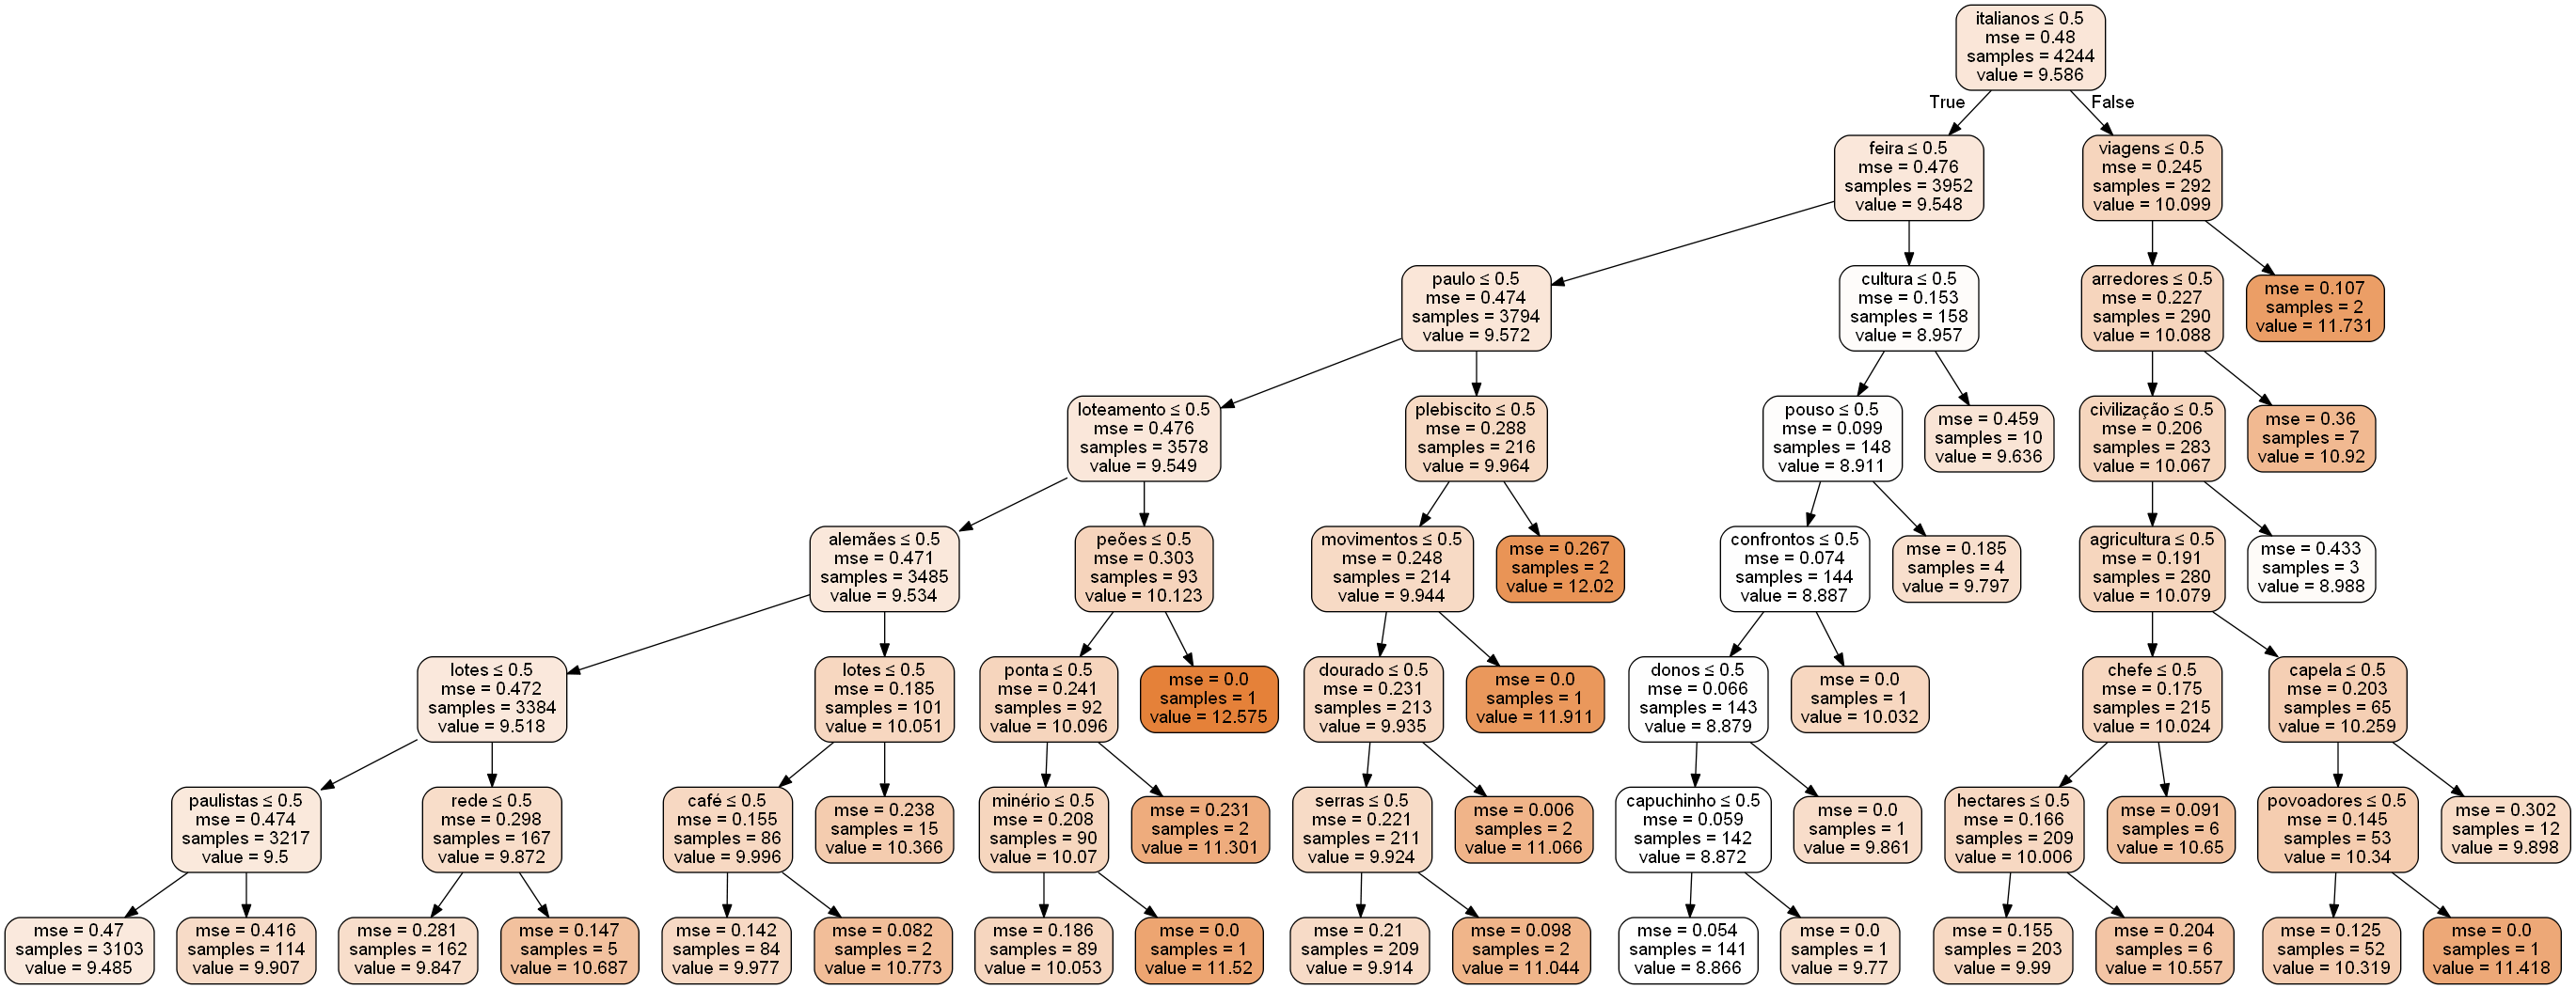

In [69]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

parameters = {'max_depth': range(3,20), 'min_samples_split': [0.005, 0.01]}

clf = GridSearchCV(tree.DecisionTreeRegressor(), parameters, n_jobs=4)
clf.fit(X_train_tfbin, y_train_tfbin)
tree_model = clf.best_estimator_

dot_data = StringIO()
export_graphviz(tree_model, out_file=dot_data, 
                feature_names=dicionario,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# Modelos

# ElasticNet - TF IDF

In [74]:
from sklearn.linear_model import ElasticNetCV

logit_tfidf = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.99, 1], 
                        eps=0.001, 
                        n_alphas=50, 
                        alphas=None, 
                        fit_intercept=True,
                        normalize=False, 
                        precompute="auto",
                        max_iter=500, 
                        tol=0.001, 
                        cv=3, 
                        copy_X=True, 
                        verbose=0, 
                        n_jobs=-1, 
                        positive=False, 
                        random_state=None, 
                        selection="cyclic").fit(train_tfidf, tbl['log_pib_pc'])

In [75]:
print("R-squared with cross-validation: " + str(logit_tfidf.score(train_tfidf, tbl["log_pib_pc"])))

R-squared with cross-validation: 0.42085560920765697


In [76]:
coefs = pd.DataFrame({"coef": dicionario, 
                      "value": logit_tfidf.coef_})

print("\nTermos associados a um PIB per capita mais ALTO:")
display(coefs.sort_values(by="value", ascending=False).head(15)) # Termos associados a um maior PIB per capita

print("\nTermos associados a um PIB per capita mais BAIXO:")
display(coefs.sort_values(by="value", ascending=False).tail(15))


Termos associados a um PIB per capita mais ALTO:


,coef,value
2043,italianos,0.979762
108,alemães,0.787574
2192,loteamento,0.770483
905,continente,0.675547
546,campos,0.668242
3740,trigo,0.656011
2721,paulistas,0.653705
2807,picadas,0.649993
3515,soja,0.642898
1782,gleba,0.642093



Termos associados a um PIB per capita mais BAIXO:


,coef,value
489,caatinga,-0.448714
2930,povoação,-0.478825
458,bovino,-0.489812
2461,municípios,-0.516537
2531,nordeste,-0.519966
336,açude,-0.526790
3009,procura,-0.535569
2023,inverno,-0.551684
2241,mandioca,-0.552529
3449,serra,-0.571014


In [77]:
coefs.to_csv('data/coefs.csv', sep=';', decimal=',', encoding='latin1')

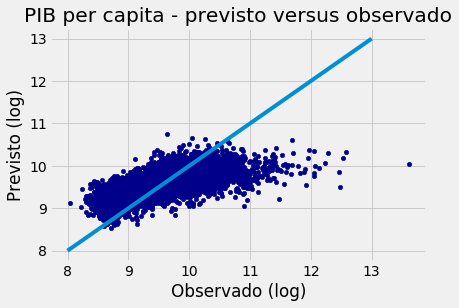

In [78]:
pd.DataFrame({"pred": logit_tfidf.predict(X_train_tfidf), "true": y_train_tfidf}).plot.scatter("true", "pred", c="darkblue")

plt.title("PIB per capita - previsto versus observado")
plt.ylabel('Previsto (log)')
plt.xlabel('Observado (log)')

plt.plot([8,13],[8,13])

Embora tenhamos um R quadrado significativamente maior com TF-IDF, ainda temos viés na estimação. A regressão subestima sistematicamente o PIB per capita em municípios ricos, e superestima o PIB per capita de municípios pobres.

Uma das razões pode ser a omissão de variáveis relevantes, pouco relacionada aos elementos capturados no histórico dos municípios. 

Por fim, vamos verificar se podemos caracterizar grupos de municípios através de seus históricos por meio de *topic modeling*:

### Topic modeling

In [79]:
from sklearn.decomposition import LatentDirichletAllocation

no_topics = 25
lda = LatentDirichletAllocation(
    n_topics=no_topics, max_iter=500, learning_method='batch', learning_offset=50.,
    random_state=0, n_jobs=-1).fit(train_tfbin)

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, train_tfbin, tf_vec_bin, R=15)

E:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
4      8.293239        1       1 -0.034659 -0.079163
1      7.469918        1       2  0.101522  0.008715
10     7.412550        1       3  0.145642 -0.126070
2      7.244603        1       4  0.126717  0.062074
0      5.510450        1       5  0.194696  0.037874
13     4.869321        1       6 -0.140282  0.060942
3      4.245960        1       7  0.143237  0.066993
22     4.110836        1       8 -0.200354 -0.019622
7      3.957436        1       9  0.019370 -0.099091
24     3.909779        1      10 -0.104525  0.236524
9      3.907990        1      11 -0.026235 -0.039242
18     3.843370        1      12  0.099346  0.141282
14     3.785321        1      13  0.116754 -0.105820
11     3.765632        1      14 -0.025395  0.089688
19     3.691934        1      15 -0.117535  0.091481
12     3.474709        1      16  0.202061 -0.074320
6      3.114525        1      17  0.038586  0.041906
21     2.996109        1      18 -0.056011 -0.127220
17     2.331187        1      19 -0.040118  0.122143
8      2.214987        1      20 -0.019964 -0.039226
5      2.103030        1      21 -0.039952  0.045680
15     2.098390        1      22 -0.166430 -0.183076
23     2.051357        1      23 -0.047552 -0.157140
20     1.834925        1      24  0.043151  0.059668
16     1.762443        1      25 -0.212070 -0.014978, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
2269  Default   649.000000         margem   649.000000  15.0000  15.0000
2923  Default  2345.000000        povoado  2345.000000  14.0000  14.0000
3318  Default  1385.000000            rio  1385.000000  13.0000  13.0000
565   Default  1248.000000         capela  1248.000000  12.0000  12.0000
1449  Default   594.000000        estrada   594.000000  11.0000  11.0000
2043  Default   349.000000      italianos   349.000000  10.0000  10.0000
340   Default   283.000000         açúcar   283.000000   9.0000   9.0000
3968  Default  1066.000000         índios  1066.000000   8.0000   8.0000
1441  Default   277.000000        estação   277.000000   7.0000   7.0000
1426  Default   268.000000       esquerda   268.000000   6.0000   6.0000
1568  Default   842.000000        fazenda   842.000000   5.0000   5.0000
1737  Default   598.000000           gado   598.000000   4.0000   4.0000
1182  Default   254.000000        direita   254.000000   3.0000   3.0000
1203  Default  1438.000000       distrito  1438.000000   2.0000   2.0000
108   Default   282.000000        alemães   282.000000   1.0000   1.0000
1285   Topic1    60.698354       eleições    63.934940   2.4378  -5.5676
3729   Topic1    11.845594            tre    12.786956   2.4133  -7.2016
966    Topic1    10.861741       corretor    11.803102   2.4066  -7.2883
3300   Topic1    21.603197       reuniões    23.604767   2.4011  -6.6007
3176   Topic1     8.894034    realizações     9.835396   2.3891  -7.4882
1080   Topic1     7.910181       dentista     8.851542   2.3773  -7.6054
1167   Topic1     7.910181         diesel     8.851542   2.3773  -7.6054
3581   Topic1     7.910181          suíço     8.851542   2.3773  -7.6054
201    Topic1    27.120989      aprovação    30.509048   2.3720  -6.3732
1054   Topic1     6.926328        debates     7.867689   2.3623  -7.7382
1344   Topic1     6.926328  entendimentos     7.867689   2.3623  -7.7382
2580   Topic1    14.668830         ofício    16.717590   2.3590  -6.9878
2377   Topic1     5.942474           mini     6.883836   2.3427  -7.8914
1954   Topic1     5.942474     indivíduos     6.883836   2.3427  -7.8914
3681   Topic1     5.942474      tocantins     6.883836   2.3427  -7.8914
...       ...          ...            ...          ...      ...      ...
1152  Topic25     4.997090           deus     5.938146   3.8659  -6.5159
2433  Topic25     4.997090        morgado   

O gráfico exibe os tópicos identificados através do modelo de *Latent Dirichlet Allocation*.

A área de cada círculo representa a frequência dos tópicos nos históricos dos municípios. <br>
A proximidade dos círculos no gráfico representam a proximidade dos tópicos no espaço das features (palavras). <br>
O gráfico à direita mostra as 15 principais palavras de um tópico, e sua frequência relativa.

### Tópicos

4: Ouro, bandeirantes, exploração, minas

9: Índios, tupi, guarani, portugueses, jesuítas, espanhóis

10: Agriculutura, pecuária, milho, café, cultivo, arroz, cultura, feijão, algodão

11: Tropeiros, ponto, estrada, viajantes, passagem, referência

12: Criação de gado

15: Comércio, produtos, transporte, mercadorias

17: Italianos, alemães, colonos, poloneses

18: Margens, rio, pau, pique, madeira

19: Açúcar, cana, engenho, aguardente, rapadura

20: Margens de rio

24: Estação, estrada, ferro, ferrovia, inauguração, ferroviária, trilhos

25: Erva, mate
